# 0 Initialise

### Import Packages

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mimic_constants import *
from os import makedirs
from xgboost import XGBClassifier
from CardiomegalyBiomarkers.Cardiomegaly_Classification.src.xgboost_functions import SplitData, train_test_xgboost, SplitDataCorrectly

/home/ays124/mimic/venv/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


### Paths

In [2]:
# Path for model location and error graphs
model_folder = 'CardiomegalyBiomarkers/Cardiomegaly_Classification/models/xgboost_idp/'
makedirs(model_folder, exist_ok=True)

### Model Parameters

In [3]:
# Data parameters
TrainTestFractions = [0.8, 0.2] # Spits of data for training/validation and testing sets
FoldFractions = [0.1] * 10 # Spits of data for folds

# XGBoost parameters
eval_metric = 'logloss'
scale_pos_weight = 0.3/0.7
colsample_bytree = 0.75
gamma = 0
lr = 0.1
subsample = 0.75

max_depth_shallow = 3
max_depth_deep = 8

early_stopping = 15

In [4]:
# Feature selection for model
base = ['subject_id', 'hadm_id', 'stay_id', 'path'] # base features

vital = ['HR_mean', 'ABPs_mean', 'ABPd_mean', 'ABPm_mean', 'NBPs_mean', 'NBPd_mean',  # vital sign features (V)
         'NBPm_mean', 'RR_mean', 'PO2_mean', 'SaO2_mean', 'PCO2_mean', 'PH_mean', 'SpO2_mean', 
         'Cholesterol_mean', 'Sodium_mean', 'Temp(F)_mean', 'FiO2_mean', 'Albumin_mean', 
         'PlateletCount_mean', 'HR_max', 'ABPs_max', 'ABPd_max', 'ABPm_max', 'NBPs_max', 
         'NBPd_max', 'NBPm_max', 'RR_max', 'PCO2_max', 'Sodium_max', 'FiO2_max', 'HR_min', 
         'ABPs_min', 'ABPd_min', 'ABPm_min', 'NBPs_min', 'NBPd_min', 'NBPm_min', 'RR_min', 
         'PCO2_min', 'SpO2_min', 'Sodium_min']


lab = ['Hemoglobin_mean', 'Lactate_mean', 'Tidal_Volume_mean', 'ALT_mean', 'Alkaline_Phosphatase_mean', # laboratory features (L)
       'Bilirubin', 'Calcium_Total_mean', 'Chloride_mean', 'Creatinine_mean', 'Glucose_mean', 
       'Magnesium_mean', 'Phosphate_mean', 'Potassium_mean', 'Troponin-T_mean', 'Urea_Nitrogren_mean', 
       'Fibrinogen', 'Hematocrit_mean', 'PTT_mean', 'WBC_mean', 'Hemoglobin_max', 'Potassium_max', 
       'Troponin-T_max', 'WBC_max', 'Hemoglobin_min', 'Potassium_min', 'WBC_min']

meta_cont = ['los', 'anchor_age']                # continuous metadata features (M)
meta_cat = ['gender']                            # categorical metadata features (M)
meta_cat_encoded = ['gender_F', 'gender_M']      # encoded catgeorical metadata features

bmrks = ['CTR', 'CPAR']     # biomarker features (BMRK)

# Select modality combinations tested (list of lists)
modalities_combinations = [[vital + lab + meta_cont + meta_cat_encoded, 'M_L_V'],
                           [bmrks, 'BMRK'], 
                           [vital + lab + meta_cont + meta_cat_encoded + bmrks, 'M_L_V_BMRK']]

# 1 Data Prepocessing

In [5]:
# Read 
data = get_master_df(idp=True)
data = standardize_mimic_ethnicity(data)
# Change name of column to indicate class deoaration
data.rename(columns={'Cardiomegaly':'class'}, inplace=True)

[TrainVal_df, Test_df] = SplitDataCorrectly(data, TrainTestFractions)

# Split trainval into folds
[Fold1_df, Fold2_df, Fold3_df, Fold4_df, Fold5_df, Fold6_df, Fold7_df, Fold8_df, Fold9_df, Fold10_df] = SplitDataCorrectly(TrainVal_df, FoldFractions)

In [6]:
# Preprocess folds for xgboost use by selecting features and encoding categorical features
Fold1_df = pd.concat([Fold1_df[base + vital + lab + meta_cont + bmrks], pd.get_dummies(Fold1_df[meta_cat]), Fold1_df['class']], axis=1)
Fold2_df = pd.concat([Fold2_df[base + vital + lab + meta_cont + bmrks], pd.get_dummies(Fold2_df[meta_cat]), Fold2_df['class']], axis=1)
Fold3_df = pd.concat([Fold3_df[base + vital + lab + meta_cont + bmrks], pd.get_dummies(Fold3_df[meta_cat]), Fold3_df['class']], axis=1)
Fold4_df = pd.concat([Fold4_df[base + vital + lab + meta_cont + bmrks], pd.get_dummies(Fold4_df[meta_cat]), Fold4_df['class']], axis=1)
Fold5_df = pd.concat([Fold5_df[base + vital + lab + meta_cont + bmrks], pd.get_dummies(Fold5_df[meta_cat]), Fold5_df['class']], axis=1)
Fold6_df = pd.concat([Fold6_df[base + vital + lab + meta_cont + bmrks], pd.get_dummies(Fold6_df[meta_cat]), Fold6_df['class']], axis=1)
Fold7_df = pd.concat([Fold7_df[base + vital + lab + meta_cont + bmrks], pd.get_dummies(Fold7_df[meta_cat]), Fold7_df['class']], axis=1)
Fold8_df = pd.concat([Fold8_df[base + vital + lab + meta_cont + bmrks], pd.get_dummies(Fold8_df[meta_cat]), Fold8_df['class']], axis=1)
Fold9_df = pd.concat([Fold9_df[base + vital + lab + meta_cont + bmrks], pd.get_dummies(Fold9_df[meta_cat]), Fold9_df['class']], axis=1)
Fold10_df = pd.concat([Fold1_df[base + vital + lab + meta_cont + bmrks], pd.get_dummies(Fold10_df[meta_cat]), Fold10_df['class']], axis=1)

# Preprocess test set for xgboost use by selecting features and encoding categorical features
Test_df = pd.concat([Test_df[base + vital + lab + meta_cont + bmrks], pd.get_dummies(Test_df[meta_cat]), Test_df['class']], axis=1)

# 2 Model Training and Testing

[0]	validation_0-logloss:0.67093	validation_1-logloss:0.68792
[0]	validation_0-logloss:0.67093	validation_1-logloss:0.68792
[1]	validation_0-logloss:0.64702	validation_1-logloss:0.67810
[1]	validation_0-logloss:0.64702	validation_1-logloss:0.67810
[2]	validation_0-logloss:0.62091	validation_1-logloss:0.66757
[2]	validation_0-logloss:0.62091	validation_1-logloss:0.66757
[3]	validation_0-logloss:0.59733	validation_1-logloss:0.66419
[3]	validation_0-logloss:0.59733	validation_1-logloss:0.66419
[4]	validation_0-logloss:0.57294	validation_1-logloss:0.65950
[4]	validation_0-logloss:0.57294	validation_1-logloss:0.65950
[5]	validation_0-logloss:0.55468	validation_1-logloss:0.65300
[5]	validation_0-logloss:0.55468	validation_1-logloss:0.65300
[6]	validation_0-logloss:0.53312	validation_1-logloss:0.65133
[6]	validation_0-logloss:0.53312	validation_1-logloss:0.65133
[7]	validation_0-logloss:0.51514	validation_1-logloss:0.64541
[7]	validation_0-logloss:0.51514	validation_1-logloss:0.64541
[8]	vali

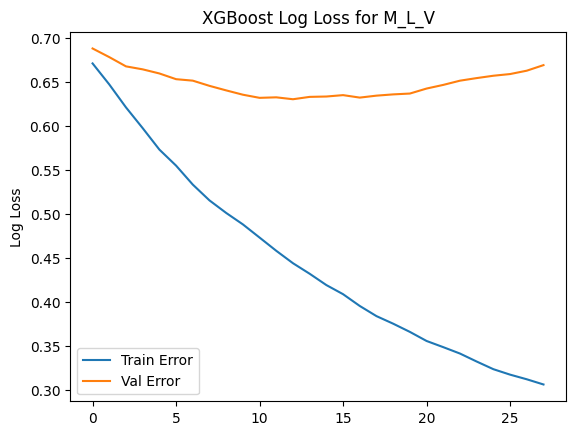

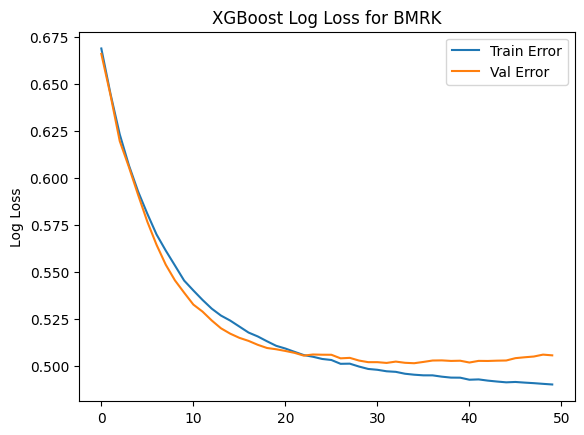

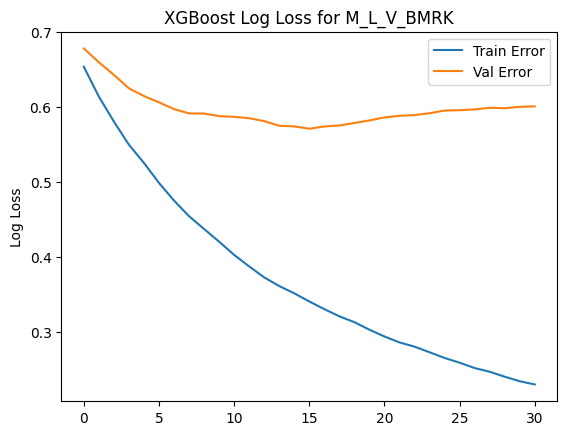

In [7]:
# define dict of model parameters
model_params = {'eval_metric' : eval_metric,
                'scale_pos_weight' : scale_pos_weight,
                'colsample_bytree' : colsample_bytree,
                'gamma' : gamma,
                'lr' : lr,
                'subsample' : subsample, 
                'max_depth_shallow' : max_depth_shallow,
                'max_depth_deep' : max_depth_deep,
                'early_stopping' : early_stopping}


# getmodels, train and test, return pandas of results using k-fold cross validation
# -> if lossFigure and saveModels are True, then figures of training and validation losses and models are saved in ./MOdel/xgboost/
results_fold1  = train_test_xgboost([Fold2_df, Fold3_df, Fold4_df, Fold5_df, Fold6_df, Fold7_df, Fold8_df, Fold9_df, Fold10_df], Fold1_df , 1,  Test_df, modalities_combinations, model_params, model_folder, lossFigure = True,  exportModels = True)
results_fold2  = train_test_xgboost([Fold1_df, Fold3_df, Fold4_df, Fold5_df, Fold6_df, Fold7_df, Fold8_df, Fold9_df, Fold10_df], Fold2_df , 2,  Test_df, modalities_combinations, model_params, model_folder, lossFigure = False, exportModels = True)
results_fold3  = train_test_xgboost([Fold1_df, Fold2_df, Fold4_df, Fold5_df, Fold6_df, Fold7_df, Fold8_df, Fold9_df, Fold10_df], Fold3_df , 3,  Test_df, modalities_combinations, model_params, model_folder, lossFigure = False, exportModels = True)
results_fold4  = train_test_xgboost([Fold1_df, Fold2_df, Fold3_df, Fold5_df, Fold6_df, Fold7_df, Fold8_df, Fold9_df, Fold10_df], Fold4_df , 4,  Test_df, modalities_combinations, model_params, model_folder, lossFigure = False, exportModels = True)
results_fold5  = train_test_xgboost([Fold1_df, Fold2_df, Fold3_df, Fold4_df, Fold6_df, Fold7_df, Fold8_df, Fold9_df, Fold10_df], Fold5_df , 5,  Test_df, modalities_combinations, model_params, model_folder, lossFigure = False, exportModels = True)
results_fold6  = train_test_xgboost([Fold1_df, Fold2_df, Fold3_df, Fold4_df, Fold5_df, Fold7_df, Fold8_df, Fold9_df, Fold10_df], Fold6_df , 6,  Test_df, modalities_combinations, model_params, model_folder, lossFigure = False, exportModels = True)
results_fold7  = train_test_xgboost([Fold1_df, Fold2_df, Fold3_df, Fold4_df, Fold5_df, Fold6_df, Fold8_df, Fold9_df, Fold10_df], Fold7_df , 7,  Test_df, modalities_combinations, model_params, model_folder, lossFigure = False, exportModels = True)
results_fold8  = train_test_xgboost([Fold1_df, Fold2_df, Fold3_df, Fold4_df, Fold5_df, Fold6_df, Fold7_df, Fold9_df, Fold10_df], Fold8_df , 8,  Test_df, modalities_combinations, model_params, model_folder, lossFigure = False, exportModels = True)
results_fold9  = train_test_xgboost([Fold1_df, Fold2_df, Fold3_df, Fold4_df, Fold5_df, Fold6_df, Fold7_df, Fold8_df, Fold10_df], Fold9_df , 9,  Test_df, modalities_combinations, model_params, model_folder, lossFigure = False, exportModels = True)
results_fold10 = train_test_xgboost([Fold1_df, Fold2_df, Fold3_df, Fold4_df, Fold5_df, Fold6_df, Fold7_df, Fold8_df, Fold9_df ], Fold10_df, 10, Test_df, modalities_combinations, model_params, model_folder, lossFigure = False, exportModels = True)


In [8]:
# These lines are inlcuded to show how to load an exported xgboost model for predictions on new data
'''
model_load = XGBClassifier()
model_load.load_model(model_folder + 'BMRK_fold1_model.json')
'''

"\nmodel_load = XGBClassifier()\nmodel_load.load_model(model_folder + 'BMRK_fold1_model.json')\n"

# 3 Results Analysis

In [15]:
# display results per fold
print(f'#######   VAL FOLD: fold 1   ########')
display(results_fold1)

print(f'#######   VAL FOLD: fold 2   ########')
display(results_fold2)

print(f'#######   VAL FOLD: fold 3   ########')
display(results_fold3)

print(f'#######   VAL FOLD: fold 4   ########')
display(results_fold4)

print(f'#######   VAL FOLD: fold 5   ########')
display(results_fold5)

print(f'#######   VAL FOLD: fold 6   ########')
display(results_fold6)

print(f'#######   VAL FOLD: fold 7   ########')
display(results_fold7)

print(f'#######   VAL FOLD: fold 8   ########')
display(results_fold8)

print(f'#######   VAL FOLD: fold 9   ########')
display(results_fold9)

print(f'#######   VAL FOLD: fold 10   ########')
display(results_fold10)

#######   VAL FOLD: fold 1   ########


,Accuracy,ROC AUC,F1 score,Confusion Matrix,Average Precision,TPR,TNR,PPV,NPV,MCC
Modalities,,,,,,,,,,
M_L_V,0.669794,0.656819,0.747126,"[[97, 58], [118, 260]]",0.783766,0.687831,0.625806,0.817610,0.451163,0.290340
BMRK,0.836773,0.844956,0.877637,"[[134, 21], [66, 312]]",0.897172,0.825397,0.864516,0.936937,0.670000,0.647096
M_L_V_BMRK,0.825516,0.825602,0.870293,"[[128, 27], [66, 312]]",0.883485,0.825397,0.825806,0.920354,0.659794,0.614650


#######   VAL FOLD: fold 2   ########


,Accuracy,ROC AUC,F1 score,Confusion Matrix,Average Precision,TPR,TNR,PPV,NPV,MCC
Modalities,,,,,,,,,,
M_L_V,0.733583,0.675149,0.812665,"[[83, 72], [70, 308]]",0.791761,0.814815,0.535484,0.810526,0.542484,0.351652
BMRK,0.834897,0.843634,0.876056,"[[134, 21], [67, 311]]",0.896413,0.822751,0.864516,0.936747,0.666667,0.643977
M_L_V_BMRK,0.831144,0.814345,0.877717,"[[120, 35], [55, 323]]",0.874147,0.854497,0.774194,0.902235,0.685714,0.607979


#######   VAL FOLD: fold 3   ########


,Accuracy,ROC AUC,F1 score,Confusion Matrix,Average Precision,TPR,TNR,PPV,NPV,MCC
Modalities,,,,,,,,,,
M_L_V,0.694184,0.653081,0.777018,"[[86, 69], [94, 284]]",0.780824,0.751323,0.554839,0.804533,0.477778,0.293994
BMRK,0.844278,0.852151,0.883590,"[[135, 20], [63, 315]]",0.901781,0.833333,0.870968,0.940299,0.681818,0.661935
M_L_V_BMRK,0.831144,0.825764,0.875691,"[[126, 29], [61, 317]]",0.882782,0.838624,0.812903,0.916185,0.673797,0.619991


#######   VAL FOLD: fold 4   ########


,Accuracy,ROC AUC,F1 score,Confusion Matrix,Average Precision,TPR,TNR,PPV,NPV,MCC
Modalities,,,,,,,,,,
M_L_V,0.677298,0.629758,0.765668,"[[80, 75], [97, 281]]",0.768763,0.743386,0.516129,0.789326,0.451977,0.250244
BMRK,0.846154,0.855376,0.884831,"[[136, 19], [63, 315]]",0.904127,0.833333,0.877419,0.943114,0.683417,0.667314
M_L_V_BMRK,0.834897,0.822700,0.879781,"[[123, 32], [56, 322]]",0.879914,0.851852,0.793548,0.909605,0.687151,0.620601


#######   VAL FOLD: fold 5   ########


,Accuracy,ROC AUC,F1 score,Confusion Matrix,Average Precision,TPR,TNR,PPV,NPV,MCC
Modalities,,,,,,,,,,
M_L_V,0.703565,0.634955,0.792651,"[[73, 82], [76, 302]]",0.770924,0.798942,0.470968,0.786458,0.489933,0.273131
BMRK,0.842402,0.850828,0.882022,"[[135, 20], [64, 314]]",0.901021,0.830688,0.870968,0.940120,0.678392,0.658773
M_L_V_BMRK,0.842402,0.833700,0.884932,"[[126, 29], [55, 323]]",0.887288,0.854497,0.812903,0.917614,0.696133,0.640011


#######   VAL FOLD: fold 6   ########


,Accuracy,ROC AUC,F1 score,Confusion Matrix,Average Precision,TPR,TNR,PPV,NPV,MCC
Modalities,,,,,,,,,,
M_L_V,0.712946,0.643472,0.800000,"[[74, 81], [72, 306]]",0.775173,0.809524,0.477419,0.790698,0.506849,0.292197
BMRK,0.846154,0.851570,0.885475,"[[134, 21], [61, 317]]",0.900967,0.838624,0.864516,0.937870,0.687179,0.662946
M_L_V_BMRK,0.827392,0.809797,0.875000,"[[119, 36], [56, 322]]",0.871256,0.851852,0.767742,0.899441,0.680000,0.599181


#######   VAL FOLD: fold 7   ########


,Accuracy,ROC AUC,F1 score,Confusion Matrix,Average Precision,TPR,TNR,PPV,NPV,MCC
Modalities,,,,,,,,,,
M_L_V,0.699812,0.626600,0.791123,"[[70, 85], [75, 303]]",0.766695,0.801587,0.451613,0.780928,0.482759,0.258390
BMRK,0.838649,0.846279,0.879213,"[[134, 21], [65, 313]]",0.897931,0.828042,0.864516,0.937126,0.673367,0.650232
M_L_V_BMRK,0.829268,0.816829,0.875513,"[[122, 33], [58, 320]]",0.876239,0.846561,0.787097,0.906516,0.677778,0.608475


#######   VAL FOLD: fold 8   ########


,Accuracy,ROC AUC,F1 score,Confusion Matrix,Average Precision,TPR,TNR,PPV,NPV,MCC
Modalities,,,,,,,,,,
M_L_V,0.709193,0.644632,0.795784,"[[76, 79], [76, 302]]",0.775871,0.798942,0.490323,0.792651,0.500000,0.290953
BMRK,0.834897,0.843634,0.876056,"[[134, 21], [67, 311]]",0.896413,0.822751,0.864516,0.936747,0.666667,0.643977
M_L_V_BMRK,0.840525,0.834281,0.883081,"[[127, 28], [57, 321]]",0.888017,0.849206,0.819355,0.919771,0.690217,0.638603


#######   VAL FOLD: fold 9   ########


,Accuracy,ROC AUC,F1 score,Confusion Matrix,Average Precision,TPR,TNR,PPV,NPV,MCC
Modalities,,,,,,,,,,
M_L_V,0.709193,0.676984,0.786207,"[[93, 62], [93, 285]]",0.793738,0.753968,0.600000,0.821326,0.500000,0.337252
BMRK,0.840525,0.849505,0.880450,"[[135, 20], [65, 313]]",0.900261,0.828042,0.870968,0.939940,0.675000,0.655629
M_L_V_BMRK,0.836773,0.822120,0.881633,"[[122, 33], [54, 324]]",0.879224,0.857143,0.787097,0.907563,0.693182,0.622112


#######   VAL FOLD: fold 10   ########


,Accuracy,ROC AUC,F1 score,Confusion Matrix,Average Precision,TPR,TNR,PPV,NPV,MCC
Modalities,,,,,,,,,,
M_L_V,0.637899,0.615301,0.723891,"[[87, 68], [125, 253]]",0.762048,0.669312,0.561290,0.788162,0.410377,0.213971
BMRK,0.842402,0.847022,0.882682,"[[133, 22], [62, 316]]",0.897889,0.835979,0.858065,0.934911,0.682051,0.654369
M_L_V_BMRK,0.774859,0.763245,0.832869,"[[114, 41], [79, 299]]",0.843837,0.791005,0.735484,0.879412,0.590674,0.497489


In [16]:
# Average performance scores over 5 folds and split per feature used
results = pd.concat([results_fold1, results_fold2, results_fold3, results_fold4, results_fold5, results_fold6, results_fold7, results_fold8, results_fold9, results_fold10])

modalities = list(set(results.index.tolist()))

for modality in modalities:
    results_summary = pd.concat([results['Accuracy'].loc[modality].describe(), results['ROC AUC'].loc[modality].describe(), results['F1 score'].loc[modality].describe()], axis=1)
    results_summary.columns = ['Accuracy', 'ROC AUC', 'F1 score']
    print(f'#######   AVG OVER 10 FOLDS: {modality}    ########')
    display(results_summary.iloc[1:3])

#######   AVG OVER 10 FOLDS: M_L_V_BMRK    ########


,Accuracy,ROC AUC,F1 score
mean,0.827392,0.816838,0.873651
std,0.019256,0.020373,0.014974


#######   AVG OVER 10 FOLDS: M_L_V    ########


,Accuracy,ROC AUC,F1 score
mean,0.694747,0.645675,0.779213
std,0.026914,0.020245,0.026823


#######   AVG OVER 10 FOLDS: BMRK    ########


,Accuracy,ROC AUC,F1 score
mean,0.840713,0.848495,0.880801
std,0.004283,0.003993,0.003473


In [17]:
for modality in modalities:
    results_summary = pd.concat([results[m].loc[modality].describe() for m in ['ROC AUC', 'Average Precision', 'TPR', 'TNR', 'PPV', 'NPV', 'F1 score', 'MCC']], axis=1)
    results_summary.columns = ['AUC', 'Average Precision', 'TPR', 'TNR', 'PPV', 'NPV', 'F1 score', 'MCC']
    print(f'#######   AVG OVER 10 FOLDS: {modality}    ########')
    display(results_summary.iloc[1:3])

#######   AVG OVER 10 FOLDS: M_L_V_BMRK    ########


,AUC,Average Precision,TPR,TNR,PPV,NPV,F1 score,MCC
mean,0.816838,0.876619,0.842063,0.791613,0.907869,0.673444,0.873651,0.606909
std,0.020373,0.012720,0.020265,0.027716,0.012379,0.030954,0.014974,0.040533


#######   AVG OVER 10 FOLDS: M_L_V    ########


,AUC,Average Precision,TPR,TNR,PPV,NPV,F1 score,MCC
mean,0.645675,0.776956,0.762963,0.528387,0.798222,0.481332,0.779213,0.285212
std,0.020245,0.010528,0.051588,0.057581,0.014167,0.036489,0.026823,0.040098


#######   AVG OVER 10 FOLDS: BMRK    ########


,AUC,Average Precision,TPR,TNR,PPV,NPV,F1 score,MCC
mean,0.848495,0.899398,0.829894,0.867097,0.938381,0.676456,0.880801,0.654625
std,0.003993,0.002605,0.005443,0.005440,0.002423,0.007244,0.003473,0.008197


# 4 Feature Importance

In [12]:
model_load = XGBClassifier()
model_load.load_model(model_folder + 'M_L_V_fold2_model.json')
# Feature importances from the trained XGBoost model
feature_importances = model_load.feature_importances_
important_features = pd.DataFrame({
    'Feature': modalities_combinations[0][0],
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

important_features.head(10)

,Feature,Importance
55,Urea_Nitrogren_mean,0.036901
8,PO2_mean,0.025779
56,Fibrinogen,0.022711
49,Creatinine_mean,0.022084
3,ABPm_mean,0.018989
0,HR_mean,0.017353
51,Magnesium_mean,0.017094
64,Hemoglobin_min,0.017080
18,PlateletCount_mean,0.016671
6,NBPm_mean,0.016563


In [13]:
model_load = XGBClassifier()
model_load.load_model(model_folder + 'BMRK_fold3_model.json')
# Feature importances from the trained XGBoost model
feature_importances = model_load.feature_importances_
important_features = pd.DataFrame({
    'Feature': modalities_combinations[1][0],
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

important_features.head(10)

,Feature,Importance
0,CTR,0.575484
1,CPAR,0.424516


In [14]:
model_load = XGBClassifier()
model_load.load_model(model_folder + 'M_L_V_BMRK_fold5_model.json')
# Feature importances from the trained XGBoost model
feature_importances = model_load.feature_importances_
important_features = pd.DataFrame({
    'Feature': modalities_combinations[2][0],
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

important_features.head(12)

,Feature,Importance
71,CTR,0.085684
72,CPAR,0.055017
3,ABPm_mean,0.021091
43,Tidal_Volume_mean,0.017711
55,Urea_Nitrogren_mean,0.016429
8,PO2_mean,0.016236
11,PH_mean,0.015712
20,ABPs_max,0.015141
40,Sodium_min,0.015129
0,HR_mean,0.014643
